# Chapter 6: Post-Treatment Bias

**When Controlling for Consequences Breaks Causal Inference**

## Goal

Understand **post-treatment bias** - what happens when you include a variable that is a **consequence** of the treatment.

**Key insight:**
- Treatment causes intermediate variable
- Intermediate variable causes outcome
- Controlling for intermediate variable **blocks the causal path**
- Treatment effect disappears (even though it's real!)

**Example**: Plant growth experiment with anti-fungal treatment

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('default')
%matplotlib inline

np.random.seed(42)

print('✓ Imports loaded')

✓ Imports loaded


In [2]:
# Import quap
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.quap import quap, QuapResult

print('✓ Loaded quap')

✓ Loaded quap


---

## Step 1: The Causal Structure

**Scenario**: Testing an anti-fungal treatment on plant growth

**The DAG:**
```
H₀ (initial height) ───→ H₁ (final height)
  ↓                       ↑
  ↓                       ↑
  ↓                       ↑
Treatment → Fungus ──────┘
```

**Causal paths:**
1. H₀ → H₁ (initial height affects final height)
2. Treatment → Fungus → H₁ (treatment reduces fungus, less fungus increases growth)

**The trap:**
- Fungus is **post-treatment** (caused by treatment)
- If you control for fungus, you block path #2
- Treatment effect vanishes!

---

## Step 2: Simulate the Data

Let's create data following the causal structure.

In [3]:
# Simulate plant growth experiment
n = 100
np.random.seed(71)

# Initial height (standardized)
h0 = np.random.normal(0, 1, n)

# Treatment: 0=control, 1=treated
treatment = np.repeat([0, 1], n//2)

# Fungus: treatment reduces fungus
# Control group has more fungus
fungus = np.random.binomial(1, 0.5 - treatment * 0.4, n)

# Final height: grows from initial height, reduced by fungus
h1 = h0 + np.random.normal(5 - 3 * fungus, 1, n)

print(f"Simulated {n} plants")
print(f"\nTreatment groups:")
print(f"  Control (0): {np.sum(treatment==0)}")
print(f"  Treated (1): {np.sum(treatment==1)}")
print(f"\nFungus presence:")
print(f"  Control group: {np.mean(fungus[treatment==0]):.1%} have fungus")
print(f"  Treated group: {np.mean(fungus[treatment==1]):.1%} have fungus")
print(f"\nFinal height:")
print(f"  Control group: {h1[treatment==0].mean():.2f} ± {h1[treatment==0].std():.2f}")
print(f"  Treated group: {h1[treatment==1].mean():.2f} ± {h1[treatment==1].std():.2f}")
print(f"\n✓ Treatment reduces fungus, increases final height!")

Simulated 100 plants

Treatment groups:
  Control (0): 50
  Treated (1): 50

Fungus presence:
  Control group: 46.0% have fungus
  Treated group: 10.0% have fungus

Final height:
  Control group: 3.73 ± 2.07
  Treated group: 5.10 ± 1.55

✓ Treatment reduces fungus, increases final height!


/tmp/ipykernel_2109612/3964824138.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(heights_by_fungus, positions=[0, 1], widths=0.5,
/tmp/ipykernel_2109612/3964824138.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax.boxplot(heights_by_treatment, positions=[0, 1], widths=0.5,


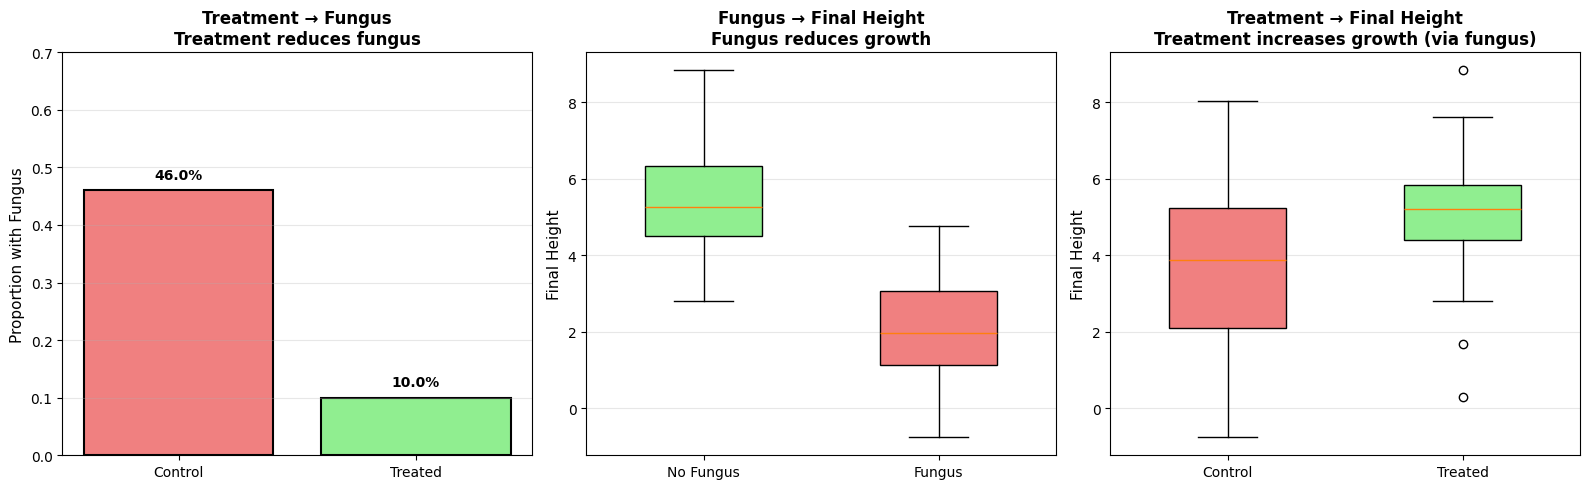


Causal pathway:
  Treatment → reduces fungus → increases final height


In [4]:
# Visualize the data
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Treatment vs Fungus
ax = axes[0]
fungus_rate = [np.mean(fungus[treatment==0]), np.mean(fungus[treatment==1])]
bars = ax.bar(['Control', 'Treated'], fungus_rate, 
              color=['lightcoral', 'lightgreen'], edgecolor='black', linewidth=1.5)
ax.set_ylabel('Proportion with Fungus', fontsize=11)
ax.set_title('Treatment → Fungus\nTreatment reduces fungus', 
             fontsize=12, fontweight='bold')
ax.set_ylim(0, 0.7)
for bar, val in zip(bars, fungus_rate):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, 
           f'{val:.1%}', ha='center', fontsize=10, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Fungus vs Height
ax = axes[1]
heights_by_fungus = [h1[fungus==0], h1[fungus==1]]
bp = ax.boxplot(heights_by_fungus, positions=[0, 1], widths=0.5,
               labels=['No Fungus', 'Fungus'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel('Final Height', fontsize=11)
ax.set_title('Fungus → Final Height\nFungus reduces growth', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Treatment vs Height (total effect)
ax = axes[2]
heights_by_treatment = [h1[treatment==0], h1[treatment==1]]
bp2 = ax.boxplot(heights_by_treatment, positions=[0, 1], widths=0.5,
                labels=['Control', 'Treated'], patch_artist=True)
bp2['boxes'][0].set_facecolor('lightcoral')
bp2['boxes'][1].set_facecolor('lightgreen')
ax.set_ylabel('Final Height', fontsize=11)
ax.set_title('Treatment → Final Height\nTreatment increases growth (via fungus)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCausal pathway:")
print("  Treatment → reduces fungus → increases final height")

---

## Step 3: Model WITHOUT Fungus - Correct Total Effect

First, let's fit the model **without** controlling for fungus.

**Model**: h₁ ~ h₀ + treatment

In [5]:
# Standardize for regression
h0_std = (h0 - h0.mean()) / h0.std()
h1_std = (h1 - h1.mean()) / h1.std()

print("Variables standardized for regression")

Variables standardized for regression


In [6]:
# Model 1: h₁ ~ h₀ + treatment (NO fungus)
def neg_log_posterior_no_fungus(params):
    alpha, beta_h0, beta_treatment, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_h0 * h0_std + beta_treatment * treatment
    log_lik = np.sum(stats.norm.logpdf(h1_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta_h0, 0, 0.5) +
                 stats.norm.logpdf(beta_treatment, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_no_fungus = quap(neg_log_posterior_no_fungus, [0, 0, 0, np.log(1)], 
                   ['alpha', 'beta_h0', 'beta_treatment', 'log_sigma'])
m_no_fungus.transform_param('log_sigma', 'sigma', np.exp)

print("Model 1: h₁ ~ h₀ + treatment (NO fungus)")
print("="*70)
m_no_fungus.summary()

✓ Registered transformation: log_sigma -> sigma
Model 1: h₁ ~ h₀ + treatment (NO fungus)
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0197 seconds
Log posterior at MAP: -127.78

                  mean    std  89%_lower  89%_upper
alpha          -0.1955 0.1032    -0.3581    -0.0295
beta_h0         0.4003 0.0836     0.2677     0.5327
beta_treatment  0.4608 0.1536     0.2161     0.7058
sigma           0.8535 0.0605     0.7606     0.9546


,mean,std,89%_lower,89%_upper
alpha,-0.195489,0.103234,-0.358131,-0.029485
beta_h0,0.400270,0.083583,0.267670,0.532696
beta_treatment,0.460784,0.153579,0.216105,0.705837
sigma,0.853517,0.060476,0.760629,0.954634


In [7]:
# Interpret results
coef_no_fungus = m_no_fungus.coef()

print("\nResults WITHOUT controlling for fungus:")
print("="*70)
print(f"β_treatment = {coef_no_fungus['beta_treatment']:.3f}")
print("\n✓ POSITIVE and SIGNIFICANT!")
print("  Treatment increases final height.")
print("  This is the CORRECT total causal effect.")
print("\n  It captures the full pathway: Treatment → Fungus → Height")


Results WITHOUT controlling for fungus:
β_treatment = 0.461

✓ POSITIVE and SIGNIFICANT!
  Treatment increases final height.
  This is the CORRECT total causal effect.

  It captures the full pathway: Treatment → Fungus → Height


---

## Step 4: Model WITH Fungus - POST-TREATMENT BIAS!

Now let's add fungus to the model and see what happens.

**Model**: h₁ ~ h₀ + treatment + fungus

In [8]:
# Model 2: h₁ ~ h₀ + treatment + fungus (WITH fungus)
def neg_log_posterior_with_fungus(params):
    alpha, beta_h0, beta_treatment, beta_fungus, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_h0 * h0_std + beta_treatment * treatment + beta_fungus * fungus
    log_lik = np.sum(stats.norm.logpdf(h1_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta_h0, 0, 0.5) +
                 stats.norm.logpdf(beta_treatment, 0, 0.5) +
                 stats.norm.logpdf(beta_fungus, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_with_fungus = quap(neg_log_posterior_with_fungus, [0, 0, 0, 0, np.log(1)], 
                     ['alpha', 'beta_h0', 'beta_treatment', 'beta_fungus', 'log_sigma'])
m_with_fungus.transform_param('log_sigma', 'sigma', np.exp)

print("Model 2: h₁ ~ h₀ + treatment + fungus (WITH fungus)")
print("="*70)
m_with_fungus.summary()

✓ Registered transformation: log_sigma -> sigma
Model 2: h₁ ~ h₀ + treatment + fungus (WITH fungus)
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0331 seconds
Log posterior at MAP: -86.60

                  mean    std  89%_lower  89%_upper
alpha           0.3325 0.0874     0.1938     0.4712
beta_h0         0.4254 0.0535     0.3393     0.5103
beta_treatment  0.0977 0.1096    -0.0768     0.2724
beta_fungus    -1.4472 0.1249    -1.6463    -1.2472
sigma           0.5381 0.0390     0.4784     0.6020


,mean,std,89%_lower,89%_upper
alpha,0.332468,0.087405,0.193769,0.471172
beta_h0,0.425417,0.053537,0.339341,0.510316
beta_treatment,0.097693,0.109622,-0.076819,0.272388
beta_fungus,-1.447154,0.124860,-1.646333,-1.247207
sigma,0.538107,0.038964,0.478385,0.601962


In [9]:
# Compare the two models
coef_with_fungus = m_with_fungus.coef()

comparison = pd.DataFrame({
    'Without Fungus': [coef_no_fungus['beta_treatment'], '—'],
    'With Fungus': [coef_with_fungus['beta_treatment'], coef_with_fungus['beta_fungus']]
}, index=['β_treatment', 'β_fungus'])

print("\nModel Comparison:")
print("="*70)
print(comparison)
print("="*70)

print("\n⚠️ POST-TREATMENT BIAS!")
print(f"\n  WITHOUT fungus: β_treatment = {coef_no_fungus['beta_treatment']:.3f}")
print("    → Shows treatment works! (CORRECT)")
print(f"\n  WITH fungus: β_treatment = {coef_with_fungus['beta_treatment']:.3f}")
print("    → Treatment effect DISAPPEARS! (WRONG)")
print(f"\n  WITH fungus: β_fungus = {coef_with_fungus['beta_fungus']:.3f}")
print("    → Fungus has strong negative effect (blocks pathway)")
print("\n💡 By controlling for fungus (a consequence), we BLOCK the causal path!")


Model Comparison:
            Without Fungus  With Fungus
β_treatment       0.460784     0.097693
β_fungus                 —    -1.447154

⚠️ POST-TREATMENT BIAS!

  WITHOUT fungus: β_treatment = 0.461
    → Shows treatment works! (CORRECT)

  WITH fungus: β_treatment = 0.098
    → Treatment effect DISAPPEARS! (WRONG)

  WITH fungus: β_fungus = -1.447
    → Fungus has strong negative effect (blocks pathway)

💡 By controlling for fungus (a consequence), we BLOCK the causal path!


---

## Step 5: Why Does This Happen?

**The causal mechanism:**

```
Treatment → Fungus → Height
```

**Without controlling for fungus:**
- We see the full effect: Treatment → reduced fungus → taller plants
- This is the **total causal effect**

**With controlling for fungus:**
- We ask: "Among plants with the SAME fungus level, does treatment matter?"
- Answer: No! Treatment only works through fungus
- We've blocked the causal pathway
- This is the **direct effect** (which is zero)

**Analogy**: It's like asking "Does studying improve test scores, holding knowledge constant?"
- Of course not! Studying works BY increasing knowledge
- Controlling for knowledge blocks the causal path

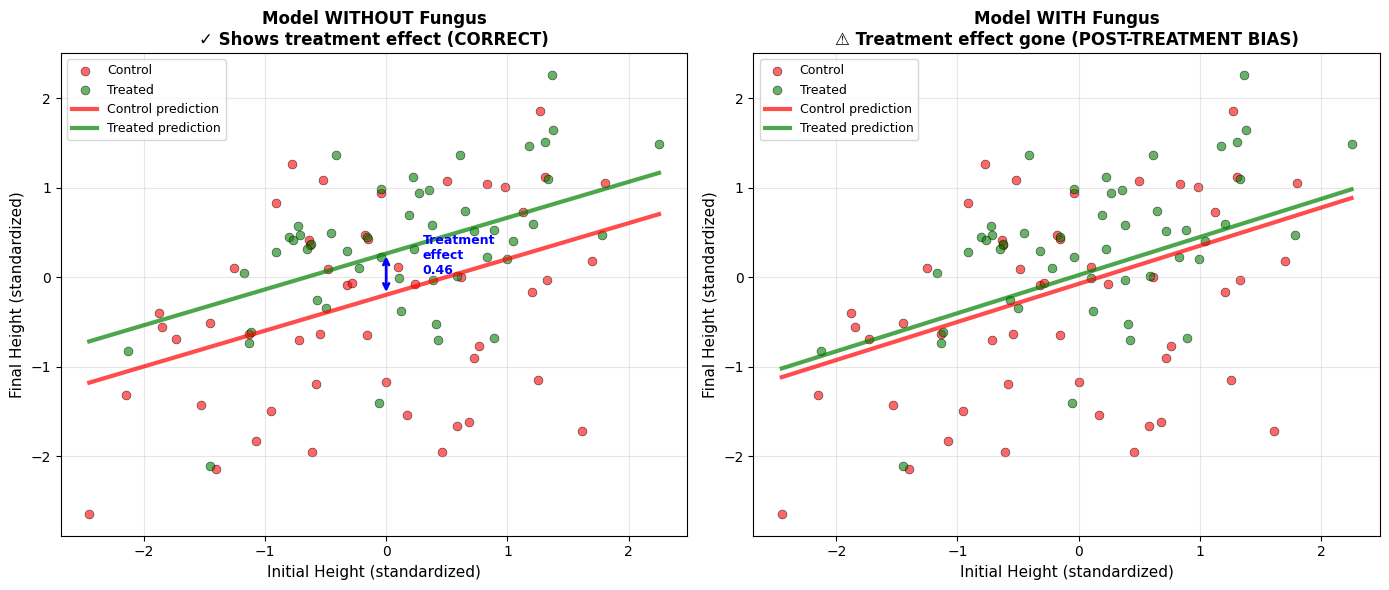


Visualization shows:
  Left: Lines separated → treatment has effect
  Right: Lines overlap → treatment effect disappears!


In [10]:
# Visualize the bias with predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Model without fungus (correct)
ax = axes[0]
# Predictions for control vs treated
h0_grid = np.linspace(h0_std.min(), h0_std.max(), 100)
pred_control = coef_no_fungus['alpha'] + coef_no_fungus['beta_h0'] * h0_grid + coef_no_fungus['beta_treatment'] * 0
pred_treated = coef_no_fungus['alpha'] + coef_no_fungus['beta_h0'] * h0_grid + coef_no_fungus['beta_treatment'] * 1

ax.scatter(h0_std[treatment==0], h1_std[treatment==0], s=40, alpha=0.6, 
          color='red', label='Control', edgecolor='black', linewidth=0.5)
ax.scatter(h0_std[treatment==1], h1_std[treatment==1], s=40, alpha=0.6, 
          color='green', label='Treated', edgecolor='black', linewidth=0.5)
ax.plot(h0_grid, pred_control, 'r-', linewidth=3, alpha=0.7, label='Control prediction')
ax.plot(h0_grid, pred_treated, 'g-', linewidth=3, alpha=0.7, label='Treated prediction')

# Add arrow showing treatment effect
mid_x = 0
mid_y_control = coef_no_fungus['alpha'] + coef_no_fungus['beta_treatment'] * 0
mid_y_treated = coef_no_fungus['alpha'] + coef_no_fungus['beta_treatment'] * 1
ax.annotate('', xy=(mid_x, mid_y_treated), xytext=(mid_x, mid_y_control),
           arrowprops=dict(arrowstyle='<->', lw=2, color='blue'))
ax.text(mid_x + 0.3, (mid_y_control + mid_y_treated)/2, 
       f'Treatment\neffect\n{coef_no_fungus["beta_treatment"]:.2f}',
       fontsize=9, color='blue', fontweight='bold')

ax.set_xlabel('Initial Height (standardized)', fontsize=11)
ax.set_ylabel('Final Height (standardized)', fontsize=11)
ax.set_title('Model WITHOUT Fungus\n✓ Shows treatment effect (CORRECT)', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Model with fungus (biased)
ax = axes[1]
# Now predictions are almost identical because we control for fungus
# Average fungus level
avg_fungus = fungus.mean()
pred_control_f = coef_with_fungus['alpha'] + coef_with_fungus['beta_h0'] * h0_grid + coef_with_fungus['beta_treatment'] * 0 + coef_with_fungus['beta_fungus'] * avg_fungus
pred_treated_f = coef_with_fungus['alpha'] + coef_with_fungus['beta_h0'] * h0_grid + coef_with_fungus['beta_treatment'] * 1 + coef_with_fungus['beta_fungus'] * avg_fungus

ax.scatter(h0_std[treatment==0], h1_std[treatment==0], s=40, alpha=0.6, 
          color='red', label='Control', edgecolor='black', linewidth=0.5)
ax.scatter(h0_std[treatment==1], h1_std[treatment==1], s=40, alpha=0.6, 
          color='green', label='Treated', edgecolor='black', linewidth=0.5)
ax.plot(h0_grid, pred_control_f, 'r-', linewidth=3, alpha=0.7, label='Control prediction')
ax.plot(h0_grid, pred_treated_f, 'g-', linewidth=3, alpha=0.7, label='Treated prediction')

ax.set_xlabel('Initial Height (standardized)', fontsize=11)
ax.set_ylabel('Final Height (standardized)', fontsize=11)
ax.set_title('Model WITH Fungus\n⚠️ Treatment effect gone (POST-TREATMENT BIAS)', 
            fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization shows:")
print("  Left: Lines separated → treatment has effect")
print("  Right: Lines overlap → treatment effect disappears!")

---

## Step 6: General Lessons

### What is Post-Treatment Bias?

**Definition**: Controlling for a variable that is a **consequence** of the treatment.

**Structure**:
```
Treatment → Mediator → Outcome
```

**Problem**: Controlling for the mediator blocks the causal pathway from treatment to outcome.

### How to Detect It

1. **Draw the DAG**: Is the variable caused by treatment?
2. **Think temporally**: Does it occur AFTER treatment?
3. **Ask**: Does treatment work THROUGH this variable?

### Common Examples

| Treatment | Post-Treatment Variable | Outcome |
|-----------|------------------------|----------|
| Education | Job skills | Income |
| Exercise | Weight loss | Health |
| Medicine | Symptoms | Recovery |
| Training | Knowledge | Test scores |

In each case, controlling for the middle variable blocks the causal effect!

### What To Do

**Don't control for post-treatment variables if you want total causal effect!**

**When to control:**
- If you specifically want the **direct effect** (e.g., does treatment do anything BESIDES reducing fungus?)
- For mediation analysis (advanced topic)

**When NOT to control:**
- If you want the **total causal effect** (usual goal)
- If the variable is an intermediate step in the causal chain

---

## Step 7: Another Example - Simulated

Let's create another example to solidify understanding: **Job training → Skills → Salary**

In [11]:
# Simulate job training example
n = 200
np.random.seed(123)

# Education level (confound)
education = np.random.normal(0, 1, n)

# Training: 0=no, 1=yes
training = np.random.binomial(1, 0.5, n)

# Skills: improved by training
skills = education + 2 * training + np.random.normal(0, 0.5, n)

# Salary: determined by skills
salary = 10 * skills + np.random.normal(0, 2, n)

# Standardize
education_std = (education - education.mean()) / education.std()
skills_std = (skills - skills.mean()) / skills.std()
salary_std = (salary - salary.mean()) / salary.std()

print(f"Job training simulation: {n} people")
print(f"\nTraining effect on skills:")
print(f"  No training: skills = {skills[training==0].mean():.2f}")
print(f"  Training: skills = {skills[training==1].mean():.2f}")
print(f"\nTraining effect on salary:")
print(f"  No training: salary = {salary[training==0].mean():.2f}")
print(f"  Training: salary = {salary[training==1].mean():.2f}")

Job training simulation: 200 people

Training effect on skills:
  No training: skills = -0.10
  Training: skills = 2.08

Training effect on salary:
  No training: salary = -0.65
  Training: salary = 20.94


In [12]:
# Model A: Salary ~ Education + Training (NO skills)
def neg_log_posterior_salary_no_skills(params):
    alpha, beta_ed, beta_train, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_ed * education_std + beta_train * training
    log_lik = np.sum(stats.norm.logpdf(salary_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta_ed, 0, 0.5) +
                 stats.norm.logpdf(beta_train, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_salary_no_skills = quap(neg_log_posterior_salary_no_skills, [0, 0, 0, np.log(1)], 
                          ['alpha', 'beta_ed', 'beta_train', 'log_sigma'])
m_salary_no_skills.transform_param('log_sigma', 'sigma', np.exp)

print("Model A: Salary ~ Education + Training (NO skills)")
print("="*70)
m_salary_no_skills.summary()

✓ Registered transformation: log_sigma -> sigma
Model A: Salary ~ Education + Training (NO skills)
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0273 seconds
Log posterior at MAP: -73.39

              mean    std  89%_lower  89%_upper
alpha      -0.5554 0.0316    -0.6054    -0.5045
beta_ed     0.6658 0.0239     0.6281     0.7040
beta_train  1.2240 0.0475     1.1477     1.2983
sigma       0.3351 0.0167     0.3093     0.3622


,mean,std,89%_lower,89%_upper
alpha,-0.555356,0.031602,-0.605367,-0.504507
beta_ed,0.665826,0.023878,0.628096,0.704034
beta_train,1.224001,0.047534,1.147705,1.298252
sigma,0.335071,0.016652,0.309279,0.362151


In [13]:
# Model B: Salary ~ Education + Training + Skills (WITH skills)
def neg_log_posterior_salary_with_skills(params):
    alpha, beta_ed, beta_train, beta_skills, log_sigma = params
    sigma = np.exp(log_sigma)
    mu = alpha + beta_ed * education_std + beta_train * training + beta_skills * skills_std
    log_lik = np.sum(stats.norm.logpdf(salary_std, loc=mu, scale=sigma))
    log_prior = (stats.norm.logpdf(alpha, 0, 0.2) +
                 stats.norm.logpdf(beta_ed, 0, 0.5) +
                 stats.norm.logpdf(beta_train, 0, 0.5) +
                 stats.norm.logpdf(beta_skills, 0, 0.5) +
                 stats.expon.logpdf(sigma, scale=1))
    return -(log_lik + log_prior + log_sigma)

m_salary_with_skills = quap(neg_log_posterior_salary_with_skills, [0, 0, 0, 0, np.log(1)], 
                            ['alpha', 'beta_ed', 'beta_train', 'beta_skills', 'log_sigma'])
m_salary_with_skills.transform_param('log_sigma', 'sigma', np.exp)

print("Model B: Salary ~ Education + Training + Skills (WITH skills)")
print("="*70)
m_salary_with_skills.summary()

✓ Registered transformation: log_sigma -> sigma
Model B: Salary ~ Education + Training + Skills (WITH skills)
QUAP POSTERIOR APPROXIMATION
Converged: True
Time: 0.0556 seconds
Log posterior at MAP: 137.18

               mean    std  89%_lower  89%_upper
alpha        0.0060 0.0197    -0.0254     0.0375
beta_ed     -0.0060 0.0203    -0.0386     0.0264
beta_train  -0.0130 0.0386    -0.0747     0.0484
beta_skills  1.0012 0.0274     0.9573     1.0455
sigma        0.1196 0.0060     0.1102     0.1294


,mean,std,89%_lower,89%_upper
alpha,0.006039,0.019741,-0.025388,0.037521
beta_ed,-0.005979,0.020275,-0.038597,0.026379
beta_train,-0.013017,0.038582,-0.074694,0.048376
beta_skills,1.001185,0.027402,0.957304,1.045458
sigma,0.119638,0.005973,0.110235,0.129362


In [14]:
# Compare
coef_no_skills = m_salary_no_skills.coef()
coef_with_skills = m_salary_with_skills.coef()

comparison2 = pd.DataFrame({
    'Without Skills': [coef_no_skills['beta_train'], '—'],
    'With Skills': [coef_with_skills['beta_train'], coef_with_skills['beta_skills']]
}, index=['β_training', 'β_skills'])

print("\nJob Training Model Comparison:")
print("="*70)
print(comparison2)
print("="*70)

print("\n⚠️ POST-TREATMENT BIAS AGAIN!")
print(f"\n  WITHOUT skills: β_training = {coef_no_skills['beta_train']:.3f}")
print("    → Training increases salary! (CORRECT total effect)")
print(f"\n  WITH skills: β_training = {coef_with_skills['beta_train']:.3f}")
print("    → Training effect DISAPPEARS! (WRONG - post-treatment bias)")
print(f"\n  WITH skills: β_skills = {coef_with_skills['beta_skills']:.3f}")
print("    → Skills strongly predict salary (blocks pathway)")
print("\n💡 Training works BY improving skills. Controlling for skills blocks this!")


Job Training Model Comparison:
           Without Skills  With Skills
β_training       1.224001    -0.013017
β_skills                —     1.001185

⚠️ POST-TREATMENT BIAS AGAIN!

  WITHOUT skills: β_training = 1.224
    → Training increases salary! (CORRECT total effect)

  WITH skills: β_training = -0.013
    → Training effect DISAPPEARS! (WRONG - post-treatment bias)

  WITH skills: β_skills = 1.001
    → Skills strongly predict salary (blocks pathway)

💡 Training works BY improving skills. Controlling for skills blocks this!


---

## Summary

### What We Learned

**1. Post-Treatment Bias Definition**
- Occurs when you control for a **consequence** of the treatment
- Blocks the causal pathway from treatment to outcome
- Makes treatment appear ineffective (even when it works!)

**2. The Causal Structure**
```
Treatment → Mediator → Outcome
```
- Mediator is POST-treatment (caused by treatment)
- Outcome is caused by mediator
- Controlling for mediator breaks the chain

**3. Examples**
- Plants: Treatment → Fungus → Height
- Jobs: Training → Skills → Salary
- Health: Medicine → Symptoms → Recovery
- Education: Study → Knowledge → Scores

**4. How to Avoid**
- Draw a DAG BEFORE modeling
- Identify post-treatment variables
- DON'T control for consequences if you want total effect
- Only control for pre-treatment confounders

**5. When It's Okay**
- Mediation analysis (explicitly studying the pathway)
- Estimating direct effects (rare)
- When you understand the causal structure

**Key insight**: Not all variables should be controlled for! Think about causality, not just correlation.

---

**Next**: Collider bias - another way controlling can go wrong!